In [ ]:
! pip install -qU "python-gdcm" pydicom pylibjpeg "opencv-python-headless" wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 72.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 65.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 76.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 20.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import os

def mount_and_navigate_to_dir(directory_path="/content/drive/MyDrive/rsna_data/"):
    """
    Mount Google Drive and navigate to a specific directory.

    Args:
    - directory_path (str): The directory to navigate to after mounting.
    """
    ROOT = "/content/drive"
    drive.mount(ROOT, force_remount=True)
    os.chdir(directory_path)
    print(f"Current directory: {os.getcwd()}")

mount_and_navigate_to_dir()

Mounted at /content/drive
Current directory: /content/drive/MyDrive/rsna_data


Notebook Color Schemes:


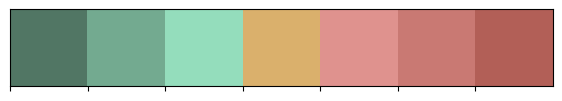

In [ ]:
# General Libraries
import os
import re
import gc
import cv2
import wandb
import random
import math
from glob import glob
from tqdm import tqdm
from pprint import pprint
from time import time
import datetime as dtime
from datetime import datetime
import itertools
import warnings
import pandas as pd
import numpy as np
import pydicom # for DICOM images
from skimage.transform import resize
from sklearn.preprocessing import LabelEncoder, normalize

# For the Visuals
import seaborn as sns
import matplotlib as mpl
from matplotlib import cm
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Rectangle
from IPython.display import display_html
plt.rcParams.update({'font.size': 16})

# Environment check
warnings.filterwarnings("ignore")
os.environ["WANDB_SILENT"] = "true"
CONFIG = {'competition': 'RSNA_Breast_Cancer', '_wandb_kernel': 'aot'}

# Custom colors
class clr:
    S = '\033[1m' + '\033[91m'
    E = '\033[0m'

my_colors = ["#517664", "#73AA90", "#94DDBC", "#DAB06C",
             "#DF928E", "#C97973", "#B25F57"]
CMAP1 = ListedColormap(my_colors)

print(clr.S+"Notebook Color Schemes:"+clr.E)
sns.palplot(sns.color_palette(my_colors))
plt.show()

!pip install -q efficientnet_pytorch
# PyTorch
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch import FloatTensor, LongTensor
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Data Augmentation for Image Preprocessing
from albumentations import (ToFloat, Normalize, VerticalFlip, HorizontalFlip, Compose, Resize,
                            RandomBrightnessContrast, HueSaturationValue, Blur, GaussNoise,
                            Rotate, RandomResizedCrop, Cutout, ShiftScaleRotate, ToGray)
from albumentations.pytorch import ToTensorV2

from efficientnet_pytorch import EfficientNet
from torchvision.models import resnet34, resnet50

# SKlearn
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

In [ ]:
train_row_data = pd.read_csv("train_dicom_row_data.csv")
train = pd.read_csv("train.csv")
train_df = pd.merge(train_row_data, train, left_on="PatientID", right_on="patient_id", how="inner")

# patient_id 열 삭제
train_df.drop(columns=["patient_id"], inplace=True)

In [ ]:
a = pd.read_csv("train_dicom_row_data.csv")
b = pd.read_csv("train.csv")
b = b[['patient_id','any_injury']]

In [ ]:
# a의 'PatientID'와 b의 'patient_id'를 기준으로 조인
merged_df = pd.merge(a, b, left_on='PatientID', right_on='patient_id', how='inner')
merged_df.drop(columns=["patient_id"], inplace=True)

# 결과 출력
merged_df

,PatientID,HighBit,PatientPosition,RescaleType,SeriesNumber,aortic_hu,ImageOrientationPatient1,ImageOrientationPatient2,ImageOrientationPatient3,ImageOrientationPatient4,ImageOrientationPatient5,ImageOrientationPatient6,PixelSpacing1,PixelSpacing2,any_injury
0,49954,15,0,0,41479,253.0,1.0,0.0,0.0,0.0,1.0,0.0,0.923000,0.923000,0
1,50737,11,1,1,59269,100.0,1.0,0.0,0.0,0.0,1.0,0.0,0.753906,0.753906,0
2,55903,15,1,1,29738,576.0,1.0,-0.0,0.0,-0.0,1.0,0.0,0.753906,0.753906,0
3,55903,15,1,1,5363,246.0,1.0,-0.0,0.0,-0.0,1.0,0.0,0.753906,0.753906,0
4,51078,15,0,1,62342,153.0,1.0,0.0,0.0,0.0,1.0,0.0,0.652344,0.652344,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4706,14790,15,0,1,7720,282.0,1.0,0.0,0.0,0.0,1.0,0.0,0.859375,0.859375,0
4707,14790,15,0,1,60494,133.0,1.0,0.0,0.0,0.0,1.0,0.0,0.859375,0.859375,0
4708,9549,15,0,0,36394,245.0,1.0,0.0,0.0,0.0,1.0,0.0,0.930000,0.930000,1
4709,9549,15,0,0,20222,132.0,1.0,0.0,0.0,0.0,1.0,0.0,0.907000,0.907000,1


In [ ]:
# dcm path 추가
path = 'train_images/' + merged_df['PatientID'].astype(str) + '/' + merged_df['SeriesNumber'].astype(str)
merged_df['path'] = 'train_images/' + merged_df['PatientID'].astype(str) + '/' + merged_df['SeriesNumber'].astype(str)

# 결과 출력
merged_df

,PatientID,HighBit,PatientPosition,RescaleType,SeriesNumber,aortic_hu,ImageOrientationPatient1,ImageOrientationPatient2,ImageOrientationPatient3,ImageOrientationPatient4,ImageOrientationPatient5,ImageOrientationPatient6,PixelSpacing1,PixelSpacing2,any_injury,path
0,49954,15,0,0,41479,253.0,1.0,0.0,0.0,0.0,1.0,0.0,0.923000,0.923000,0,train_images/49954/41479
1,50737,11,1,1,59269,100.0,1.0,0.0,0.0,0.0,1.0,0.0,0.753906,0.753906,0,train_images/50737/59269
2,55903,15,1,1,29738,576.0,1.0,-0.0,0.0,-0.0,1.0,0.0,0.753906,0.753906,0,train_images/55903/29738
3,55903,15,1,1,5363,246.0,1.0,-0.0,0.0,-0.0,1.0,0.0,0.753906,0.753906,0,train_images/55903/5363
4,51078,15,0,1,62342,153.0,1.0,0.0,0.0,0.0,1.0,0.0,0.652344,0.652344,0,train_images/51078/62342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4706,14790,15,0,1,7720,282.0,1.0,0.0,0.0,0.0,1.0,0.0,0.859375,0.859375,0,train_images/14790/7720
4707,14790,15,0,1,60494,133.0,1.0,0.0,0.0,0.0,1.0,0.0,0.859375,0.859375,0,train_images/14790/60494
4708,9549,15,0,0,36394,245.0,1.0,0.0,0.0,0.0,1.0,0.0,0.930000,0.930000,1,train_images/9549/36394
4709,9549,15,0,0,20222,132.0,1.0,0.0,0.0,0.0,1.0,0.0,0.907000,0.907000,1,train_images/9549/20222


In [ ]:
import pandas as pd
import numpy as np
import pydicom
import torch
import torch.nn as nn
from torchvision.models import resnet50
from torch.utils.data import DataLoader, Dataset
from albumentations import Compose, RandomResizedCrop, ShiftScaleRotate, HorizontalFlip, VerticalFlip
import matplotlib.pyplot as plt
# from albumentations import Compose, Resize, ShiftScaleRotate, HorizontalFlip, VerticalFlip, ToTensorV2

# RSNADataset 클래스 정의
class RSNADataset(Dataset):
    def __init__(self, dataframe, vertical_flip, horizontal_flip, is_train=True):
        self.dataframe, self.is_train = dataframe, is_train
        self.vertical_flip, self.horizontal_flip = vertical_flip, horizontal_flip
        if is_train:
            self.transform = Compose([Resize(height=225, width=225),
                                      ShiftScaleRotate(rotate_limit=90, scale_limit=[0.8, 1.2]),
                                      HorizontalFlip(p=self.horizontal_flip),
                                      VerticalFlip(p=self.vertical_flip),
                                      ToTensorV2()])
        else:
            self.transform = Compose([Resize(height=225, width=225),
                                      ToTensorV2()])


    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        folder_path = row['path']
        file_list = sorted(os.listdir(folder_path), key=lambda x: int(x.split('.')[0]))
        image_path1 = folder_path + '/' + file_list[len(file_list)//2-1]
        print(image_path1)
        image_path2 = folder_path + '/' + file_list[len(file_list)//2]
        image_path3 = folder_path + '/' + file_list[len(file_list)//2+1]
        image1 = pydicom.dcmread(image_path1).pixel_array.astype(np.float32)
        image2 = pydicom.dcmread(image_path2).pixel_array.astype(np.float32)
        image3 = pydicom.dcmread(image_path3).pixel_array.astype(np.float32)
        csv_data = np.array(row[['HighBit', 'PatientPosition', 'RescaleType', 'aortic_hu', 'ImageOrientationPatient1', 'ImageOrientationPatient2', 'ImageOrientationPatient3',
                                'ImageOrientationPatient4', 'ImageOrientationPatient5', 'ImageOrientationPatient6', 'PixelSpacing1', 'PixelSpacing2']].values, dtype=np.float32)
        transf_image1 = self.transform(image=image1)['image']
        transf_image2 = self.transform(image=image2)['image']
        transf_image3 = self.transform(image=image3)['image']
        transf_image = np.concatenate([transf_image1, transf_image2, transf_image3], axis=0)
        if self.is_train:
            return {"image": transf_image, "meta": csv_data, "target": row['any_injury']}
        else:
            return {"image": transf_image, "meta": csv_data}

# 모델 클래스 정의
class ResNet50Network(nn.Module):
    def __init__(self, output_size, no_columns):
        super().__init__()
        self.no_columns, self.output_size = no_columns, output_size
        self.features = resnet50(pretrained=True)
        self.csv = nn.Sequential(nn.Linear(self.no_columns, 500),
                                 nn.BatchNorm1d(500),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2))
        self.classification = nn.Linear(1000 + 500, output_size)

    def forward(self, image, meta):
        image = self.features(image)
        meta = self.csv(meta)
        image_meta_data = torch.cat((image, meta), dim=1)
        out = self.classification(image_meta_data)
        return out

selected_df = merged_df.iloc[9:18]
print(selected_df)

# # 테스트 데이터셋 및 DataLoader 생성p
test_dataset = RSNADataset(selected_df, vertical_flip=0.5, horizontal_flip=0.5, is_train=True)
test_dataloader = DataLoader(test_dataset, batch_size=3, shuffle=False)

# Device 설정 및 모델 초기화
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
no_columns = len(selected_df.columns) - 4
output_size = 1
model = ResNet50Network(output_size=output_size, no_columns=no_columns).to(DEVICE)

# 모델 테스트
model.eval()
criterion = nn.BCEWithLogitsLoss()
# 하이퍼파라미터 설정
learning_rate = 0.001
num_epochs = 20

# 옵티마이저 및 모델 초기화
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 손실 기록을 저장할 리스트 초기화
losses = []

# 에포크 수만큼 훈련
for epoch in range(num_epochs):
    model.train()  # 모델을 훈련 모드로 설정
    running_loss = 0.0
    for data in test_dataloader:
        # 데이터 로드
        image, meta, targets = data['image'].to(DEVICE), data['meta'].to(DEVICE), data['target'].to(DEVICE)

        # 그래디언트 초기화
        optimizer.zero_grad()

        # 순전파
        outputs = model(image, meta)

        # 손실 계산
        loss = criterion(outputs.squeeze(), targets.float())

        # 역전파
        loss.backward()

        # 옵티마이저 단계
        optimizer.step()

        running_loss += loss.item() * image.size(0)

    epoch_loss = running_loss / len(test_dataloader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    # 손실 기록 저장
    losses.append(epoch_loss)

# 손실 시각화
plt.plot(losses, '-o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

    PatientID  HighBit  PatientPosition  RescaleType  SeriesNumber  aortic_hu  \
9       43461       15                0            1          5479      191.0   
10      42412       12                1            0         42903      110.0   
11      62763       15                0            1          7397      191.0   
12      62763       15                0            1         60302      336.0   
13      29831       11                1            1         12529      224.0   
14       1960       15                0            1         13901      203.0   
15      25095       15                0            0         55034      284.0   
16      50916       11                1            1          8313      129.0   
17      50916       11                1            1         15449      243.0   

    ImageOrientationPatient1  ImageOrientationPatient2  \
9                        1.0                      -0.0   
10                       1.0                       0.0   
11             

KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt

# 모델의 pretrained 가중치 로드
model = resnet50(pretrained=True)

# 첫 번째 Convolutional Layer의 가중치 가져오기
weights = model.conv1.weight.data.cpu().numpy()

# 가중치의 shape 확인 (64, 3, 7, 7) -> 64개의 3채널 7x7 필터
print("Shape of the weights:", weights.shape)

# 처음 8개의 필터만 시각화
# n_filters_to_show = weights.shape[0]
n_filters_to_show = 8
fig, axs = plt.subplots(n_filters_to_show, 3, figsize=(15, 20))

for i in range(n_filters_to_show):
    for j in range(3):  # 3 RGB 채널
        axs[i, j].imshow(weights[i, j, :, :], cmap='gray')
        axs[i, j].axis('off')

plt.show()


In [ ]:
import pandas as pd
import numpy as np
import pydicom
import torch
import torch.nn as nn
from torchvision.models import resnet50
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from albumentations import (ToFloat, Normalize, VerticalFlip, HorizontalFlip, Compose, Resize,
                            RandomBrightnessContrast, HueSaturationValue, Blur, GaussNoise,
                            Rotate, RandomResizedCrop, Cutout, ShiftScaleRotate, ToGray)
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

# RSNADataset 클래스 정의
class RSNADataset(Dataset):
    def __init__(self, dataframe, vertical_flip, horizontal_flip, is_train=True):
        self.dataframe, self.is_train = dataframe, is_train
        self.vertical_flip, self.horizontal_flip = vertical_flip, horizontal_flip
        if is_train:
            self.transform = Compose([Resize(height=225, width=225),
                                      ShiftScaleRotate(rotate_limit=90, scale_limit=[0.8, 1.2]),
                                      HorizontalFlip(p=self.horizontal_flip),
                                      VerticalFlip(p=self.vertical_flip),
                                      ToTensorV2()])
        else:
            self.transform = Compose([Resize(height=225, width=225),
                                      ToTensorV2()])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        folder_path = row['path']
        file_list = sorted(os.listdir(folder_path), key=lambda x: int(x.split('.')[0]))
        image_path1 = folder_path + '/' + file_list[len(file_list)//2-1]
        image_path2 = folder_path + '/' + file_list[len(file_list)//2]
        image_path3 = folder_path + '/' + file_list[len(file_list)//2+1]
        image1 = pydicom.dcmread(image_path1).pixel_array.astype(np.float32)
        image2 = pydicom.dcmread(image_path2).pixel_array.astype(np.float32)
        image3 = pydicom.dcmread(image_path3).pixel_array.astype(np.float32)

        csv_data = np.array(row[['HighBit', 'PatientPosition', 'RescaleType', 'aortic_hu', 'ImageOrientationPatient1', 'ImageOrientationPatient2', 'ImageOrientationPatient3',
                                'ImageOrientationPatient4', 'ImageOrientationPatient5', 'ImageOrientationPatient6', 'PixelSpacing1', 'PixelSpacing2']].values, dtype=np.float32)

        transf_image1 = self.transform(image=image1)['image']
        transf_image2 = self.transform(image=image2)['image']
        transf_image3 = self.transform(image=image3)['image']
        transf_image = np.concatenate([transf_image1, transf_image2, transf_image3], axis=0)
        if self.is_train:
            return {"image": transf_image, "meta": csv_data, "target": row['any_injury']}
        else:
            return {"image": transf_image, "meta": csv_data}

# 모델 클래스 정의
class ResNet50Network(nn.Module):
    def __init__(self, output_size, no_columns):
        super().__init__()
        self.no_columns, self.output_size = no_columns, output_size
        self.features = resnet50(pretrained=True)
        self.csv = nn.Sequential(nn.Linear(self.no_columns, 500),
                                 nn.BatchNorm1d(500),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2))
        self.classification = nn.Linear(1000 + 500, output_size)

    def forward(self, image, meta):
        image = self.features(image)
        meta = self.csv(meta)
        image_meta_data = torch.cat((image, meta), dim=1)
        out = self.classification(image_meta_data)
        return out

vertical_flip = 0.5
horizontal_flip = 0.5
output_size = 1

selected_df = merged_df.iloc[:100]

# 테스트 데이터셋 및 DataLoader 생성
negative = selected_df[selected_df['any_injury'] == 0]
positive = selected_df[selected_df['any_injury'] == 1]

num_samples = min(len(negative), len(positive))
negative_samples = negative.sample(n=num_samples, random_state=1234)
positive_samples = positive.sample(n=num_samples, random_state=1234)
same_num_df = pd.concat([negative_samples, positive_samples], axis=0)

train_data, valid_data = train_test_split(same_num_df, stratify=same_num_df['any_injury'], test_size=0.2, shuffle=True, random_state=1234)
train_data = RSNADataset(train_data, vertical_flip, horizontal_flip, is_train=True)
valid_data = RSNADataset(valid_data, vertical_flip, horizontal_flip,is_train=True)
train_loader = DataLoader(train_data, batch_size=4, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_data, batch_size=4, shuffle=False, num_workers=2)

# Device 설정 및 모델 초기화
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
no_columns = len(selected_df.columns) - 4
output_size = 1
model = ResNet50Network(output_size=output_size, no_columns=no_columns).to(DEVICE)

# 하이퍼파라미터 설정
learning_rate = 0.001
num_epochs = 20

# Criterion 및 optimizer 설정
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCEWithLogitsLoss()

# 손실 기록을 저장할 리스트 초기화
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# 에포크 수만큼 훈련
for epoch in range(num_epochs):
    model.train()  # 모델을 훈련 모드로 설정
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for k, data in tqdm(enumerate(train_loader)):
        # 데이터 로드
        image, meta, targets = data['image'].to(DEVICE), data['meta'].to(DEVICE), data['target'].to(DEVICE)

        # 그래디언트 초기화
        optimizer.zero_grad()

        # 순전파
        outputs = model(image, meta)

        # 손실 계산
        loss = criterion(outputs.squeeze(), targets.float())

        # 역전파
        loss.backward()

        # 옵티마이저 단계
        optimizer.step()

        running_loss += loss.item() * image.size(0)

        predicted = torch.round(torch.sigmoid(outputs.squeeze()))  # 시그모이드 함수를 적용하여 예측값을 0 또는 1로 바꿉니다.
        print(predicted)
        #print(targets)
        #print((predicted == targets).sum().item())
        correct_train += (predicted == targets).sum().item()
        total_train += targets.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

    test_loss = 0.0
    correct_test = 0
    total_test = 0
    model.eval()
    with torch.no_grad():
        for k, data in enumerate(valid_loader):
            image, meta, targets = data['image'].to(DEVICE), data['meta'].to(DEVICE), data['target'].to(DEVICE)
            outputs = model(image, meta)
            loss = criterion(outputs.squeeze(), targets.float())
            test_loss += loss.item()

            predicted = torch.round(torch.sigmoid(outputs.squeeze()))
            print(predicted)
            #print(targets)
            #print((predicted == targets).sum().item())
            correct_test += (predicted == targets).sum().item()
            total_test += targets.size(0)

    epoch_loss = test_loss / len(valid_loader.dataset)
    test_losses.append(epoch_loss)
    test_accuracy = correct_test / total_test
    test_accuracies.append(test_accuracy)
    print(f'Epoch {epoch + 1}/{num_epochs}, Test Loss: {epoch_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

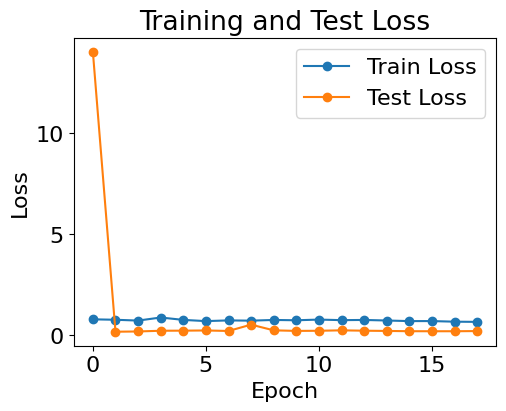

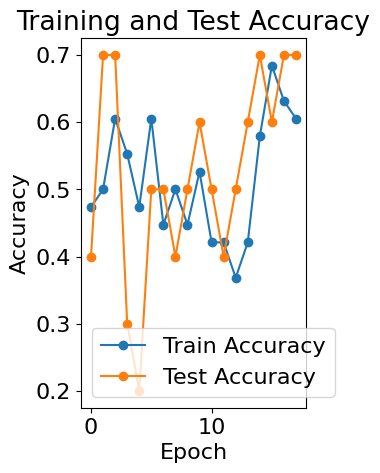

In [ ]:
# 손실 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(train_losses[2:], '-o', label='Train Loss')
plt.plot(test_losses[2:], '-o', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

# 정확도 시각화
plt.subplot(1, 2, 2)
plt.plot(train_accuracies[2:], '-o', label='Train Accuracy')
plt.plot(test_accuracies[2:], '-o', label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()
plt.show()

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # loss와 accuracy를 저장할 리스트
    loss_history = []
    accuracy_history = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 각 에폭은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for inputs, labels in dataloaders[phase]:
                optimizer.zero_grad()

                # forward
                # 학습 시에만 연산 기록 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # loss와 accuracy를 기록
            if phase == 'train':
                loss_history.append(epoch_loss)
                accuracy_history.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # 모델을 깊은 복사(deep copy)함
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 최적의 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model, loss_history, accuracy_history


In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# optimizer 정의
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# scheduler 정의
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)


In [ ]:
import time
import copy
def plot_training_history(loss_history, accuracy_history):
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(loss_history, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(accuracy_history, label='Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# 모델, loss 함수, optimizer, scheduler 등을 정의한 후
# 다음과 같이 학습 함수를 호출하고 결과를 plotting 할 수 있습니다.
model, loss_history, accuracy_history = train_model(model, criterion, optimizer, scheduler, num_epochs=25)
plot_training_history(loss_history, accuracy_history)


Epoch 0/24
----------


NameError: ignored

Shape of the weights of conv1: (64, 3, 7, 7)


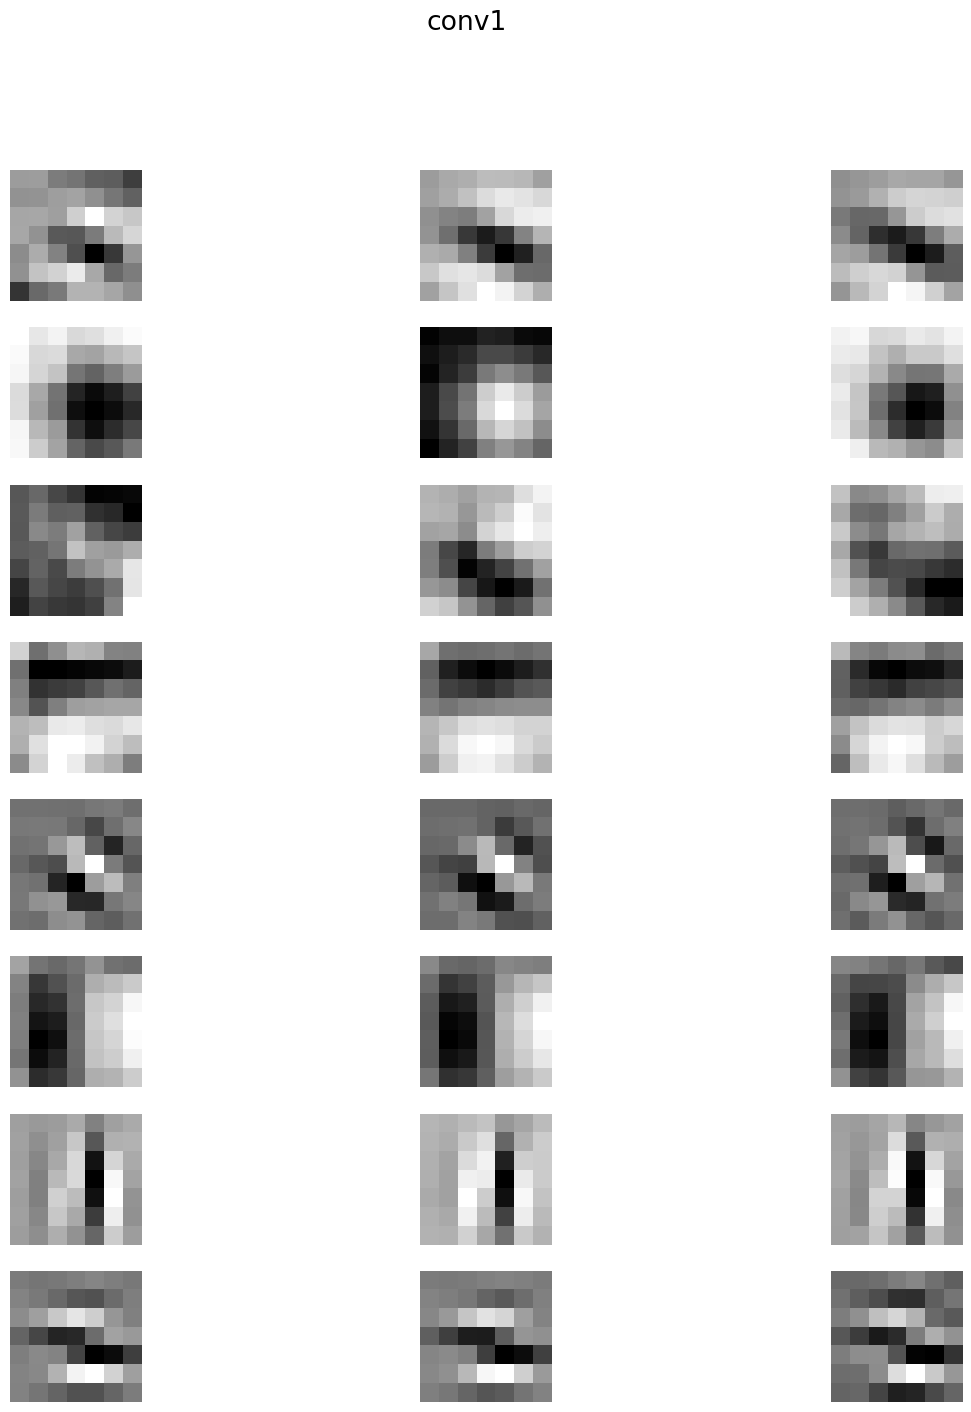

Shape of the weights of layer1.0.conv1: (64, 64, 1, 1)


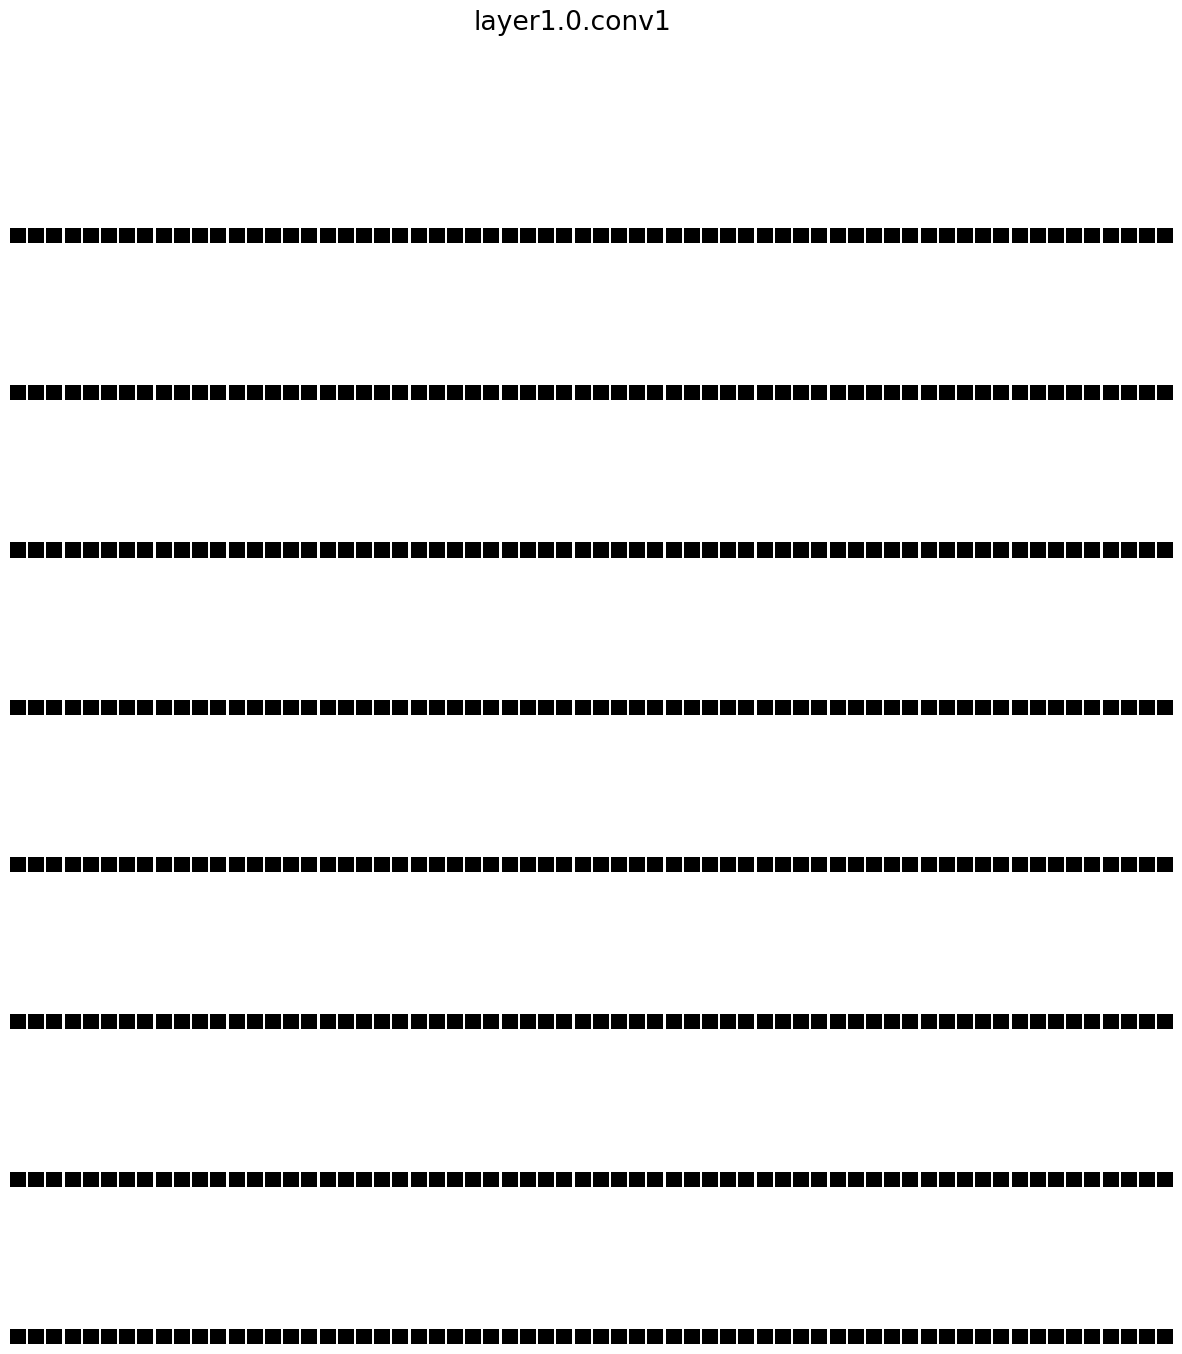

Shape of the weights of layer1.0.conv2: (64, 64, 3, 3)


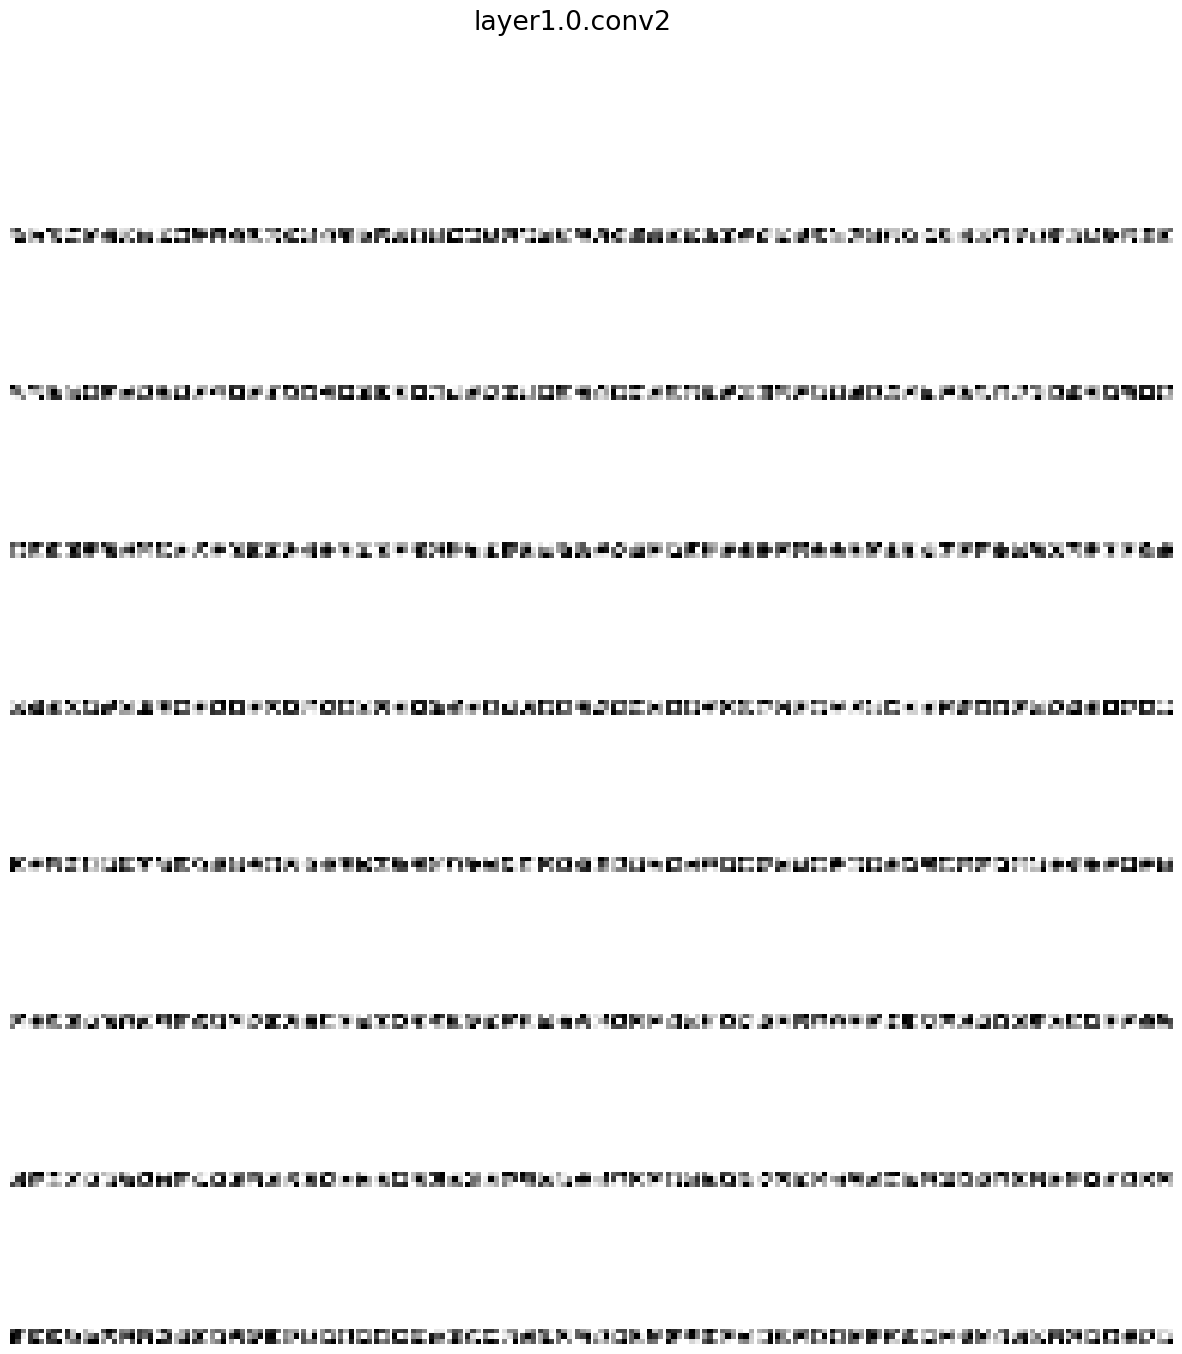

Shape of the weights of layer1.0.conv3: (256, 64, 1, 1)


KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt
from torchvision.models import resnet50

# 모델의 pretrained 가중치 로드
model = resnet50(pretrained=True)

# 모델의 모든 레이어를 순회하며 컨볼루션 레이어 찾기
for name, layer in model.named_modules():
    if isinstance(layer, nn.Conv2d):
        # 컨볼루션 레이어의 가중치 가져오기
        weights = layer.weight.data.cpu().numpy()

        # 가중치의 shape 확인
        print(f"Shape of the weights of {name}:", weights.shape)

        # 필터의 갯수와 채널 수
        n_filters, n_channels = weights.shape[:2]

        # 필터의 갯수가 많을 경우, 시각화하는 필터 수 제한
        n_filters_to_show = min(n_filters, 8)

        # 시각화
        fig, axs = plt.subplots(n_filters_to_show, n_channels, figsize=(15, 2 * n_filters_to_show))
        fig.suptitle(name)

        for i in range(n_filters_to_show):
            for j in range(n_channels):
                axs[i, j].imshow(weights[i, j, :, :], cmap='gray')
                axs[i, j].axis('off')
        plt.show()



In [ ]:
!pip install timm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.8 MB/s eta 0:00:00


    PatientID  HighBit  PatientPosition  RescaleType  SeriesNumber  aortic_hu  \
9       43461       15                0            1          5479      191.0   
10      42412       12                1            0         42903      110.0   
11      62763       15                0            1          7397      191.0   
12      62763       15                0            1         60302      336.0   
13      29831       11                1            1         12529      224.0   
14       1960       15                0            1         13901      203.0   
15      25095       15                0            0         55034      284.0   
16      50916       11                1            1          8313      129.0   
17      50916       11                1            1         15449      243.0   

    ImageOrientationPatient1  ImageOrientationPatient2  \
9                        1.0                      -0.0   
10                       1.0                       0.0   
11             

Epoch 1/20, Loss: 0.7034
Epoch 2/20, Loss: 0.5009
Epoch 3/20, Loss: 0.3628
Epoch 4/20, Loss: 0.4632
Epoch 5/20, Loss: 0.2818
Epoch 6/20, Loss: 0.3626
Epoch 7/20, Loss: 0.1840
Epoch 8/20, Loss: 0.4563
Epoch 9/20, Loss: 0.1954
Epoch 10/20, Loss: 0.3398
Epoch 11/20, Loss: 0.1610
Epoch 12/20, Loss: 0.1922
Epoch 13/20, Loss: 0.3466
Epoch 14/20, Loss: 0.2392
Epoch 15/20, Loss: 0.3498
Epoch 16/20, Loss: 0.1074
Epoch 17/20, Loss: 0.1379
Epoch 18/20, Loss: 0.9166
Epoch 19/20, Loss: 0.1834
Epoch 20/20, Loss: 0.3472


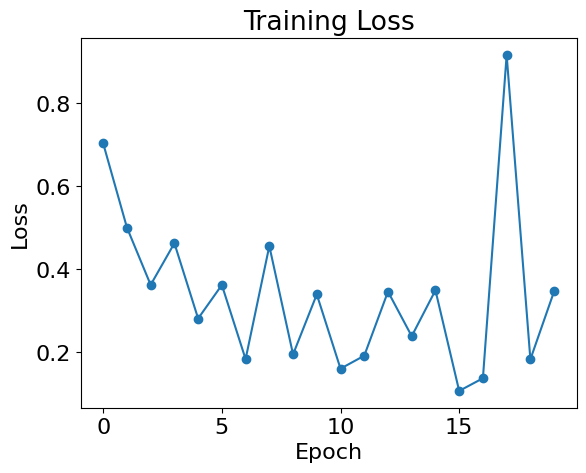

In [ ]:
import pandas as pd
import numpy as np
import pydicom
import torch
import torch.nn as nn
from torchvision.models import resnet50
from torch.utils.data import DataLoader, Dataset
from albumentations import Compose, RandomResizedCrop, ShiftScaleRotate, HorizontalFlip, VerticalFlip
import matplotlib.pyplot as plt

# RSNADataset 클래스 정의
class RSNADataset(Dataset):
    def __init__(self, dataframe, vertical_flip, horizontal_flip, is_train=True):
        self.dataframe, self.is_train = dataframe, is_train
        self.vertical_flip, self.horizontal_flip = vertical_flip, horizontal_flip
        if is_train:
            self.transform = Compose([
                # 이미지 크기 조절
                Resize(height=256, width=256),
                # 좌우 뒤집기 (수평 뒤집기) 및 상하 뒤집기 (수직 뒤집기)
                HorizontalFlip(p=self.horizontal_flip),
                VerticalFlip(p=self.vertical_flip),
                # 랜덤 회전 (90도 단위)
                RandomRotate90(p=0.5),
                # 이미지 이동, 크기 조절 및 회전
                ShiftScaleRotate(rotate_limit=20, scale_limit=0.1, p=0.5),
                # 랜덤한 밝기와 대비 조절
                RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
                # 가우시안 노이즈 추가
                GaussNoise(p=0.2),
                # 이미지를 실수형으로 변환
                ToFloat(max_value=255.0),
                # 이미지 정규화
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                # 이미지를 PyTorch 텐서로 변환
                ToTensorV2(),
            ])
        else:
            self.transform = Compose([ToTensorV2()])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        folder_path = row['path']
        file_list = sorted(os.listdir(folder_path), key=lambda x: int(x.split('.')[0]))
        image_path1 = folder_path + '/' + file_list[len(file_list)//2-1]
        image_path2 = folder_path + '/' + file_list[len(file_list)//2]
        image_path3 = folder_path + '/' + file_list[len(file_list)//2+1]
        image1 = pydicom.dcmread(image_path1).pixel_array.astype(np.float32)
        image2 = pydicom.dcmread(image_path2).pixel_array.astype(np.float32)
        image3 = pydicom.dcmread(image_path3).pixel_array.astype(np.float32)
        csv_data = np.array(row[['HighBit', 'PatientPosition', 'RescaleType', 'aortic_hu', 'ImageOrientationPatient1', 'ImageOrientationPatient2', 'ImageOrientationPatient3',
                                'ImageOrientationPatient4', 'ImageOrientationPatient5', 'ImageOrientationPatient6', 'PixelSpacing1', 'PixelSpacing2']].values, dtype=np.float32)
        transf_image1 = self.transform(image=image1)['image']
        transf_image2 = self.transform(image=image2)['image']
        transf_image3 = self.transform(image=image3)['image']
        transf_image = np.concatenate([transf_image1, transf_image2, transf_image3], axis=0)
        if self.is_train:
            return {"image": transf_image, "meta": csv_data, "target": row['any_injury']}
        else:
            return {"image": transf_image, "meta": csv_data}
import timm

class EfficientNetNetwork(nn.Module):
    def __init__(self, output_size, no_columns):
        super().__init__()
        self.no_columns, self.output_size = no_columns, output_size
        self.features = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.features.children())[:-1])  # 마지막 FC 레이어 제거
        self.csv = nn.Sequential(nn.Linear(self.no_columns, 500),
                                 nn.BatchNorm1d(500),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2))
        self.classification = nn.Linear(1280 + 500, output_size)  # efficientnet_b0의 feature 크기는 1280

    def forward(self, image, meta):
        image = self.features(image)
        image = image.squeeze(-1).squeeze(-1)  # Global Average Pooling 이후 차원 축소
        meta = self.csv(meta)
        image_meta_data = torch.cat((image, meta), dim=1)
        out = self.classification(image_meta_data)
        return out

selected_df = merged_df.iloc[9:18]
print(selected_df)

# # 테스트 데이터셋 및 DataLoader 생성p
test_dataset = RSNADataset(selected_df, vertical_flip=0.5, horizontal_flip=0.5, is_train=True)
test_dataloader = DataLoader(test_dataset, batch_size=3, shuffle=False)

# Device 설정 및 모델 초기화
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
no_columns = len(selected_df.columns) - 4
output_size = 1
model = EfficientNetNetwork(output_size=output_size, no_columns=no_columns).to(DEVICE)

# 모델 테스트
model.eval()
criterion = nn.BCEWithLogitsLoss()
# 하이퍼파라미터 설정
learning_rate = 0.001
num_epochs = 20

# 옵티마이저 및 모델 초기화
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 손실 기록을 저장할 리스트 초기화
losses = []

# 에포크 수만큼 훈련
for epoch in range(num_epochs):
    model.train()  # 모델을 훈련 모드로 설정
    running_loss = 0.0
    for data in test_dataloader:
        # 데이터 로드
        image, meta, targets = data['image'].to(DEVICE), data['meta'].to(DEVICE), data['target'].to(DEVICE)

        # 그래디언트 초기화
        optimizer.zero_grad()

        # 순전파
        outputs = model(image, meta)

        # 손실 계산
        loss = criterion(outputs.squeeze(), targets.float())

        # 역전파
        loss.backward()

        # 옵티마이저 단계
        optimizer.step()

        running_loss += loss.item() * image.size(0)

    epoch_loss = running_loss / len(test_dataloader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    # 손실 기록 저장
    losses.append(epoch_loss)

# 손실 시각화
plt.plot(losses, '-o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import pydicom
import torch
import torch.nn as nn
import os
# from torchvision.transforms import ToTensorV2
from torch.utils.data import DataLoader, Dataset
from albumentations import Compose, RandomResizedCrop, ShiftScaleRotate, HorizontalFlip, VerticalFlip
import matplotlib.pyplot as plt
import timm
from time import time
import datetime as dtime
from tqdm import tqdm
from sklearn.metrics import accuracy_score, roc_auc_score
from torch.optim.lr_scheduler import ReduceLROnPlateau


In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision.models import resnet50
import pydicom
import timm
from albumentations import Compose, RandomResizedCrop, ShiftScaleRotate, HorizontalFlip, VerticalFlip
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, roc_auc_score
from torch.optim.lr_scheduler import ReduceLROnPlateau
from time import time
import datetime as dtime
import gc



def train_folds(model, train_original, FOLDS, BATCH_SIZE1, BATCH_SIZE2, WORKERS, LR, WD, LR_PATIENCE, LR_FACTOR, PATIENCE, EPOCHS, vertical_flip, horizontal_flip):

    f = open("logs.txt", "w+")

    group_fold = GroupKFold(n_splits=FOLDS)

    k_folds = group_fold.split(X=np.zeros(len(train_original)),
                               y=train_original['any_injury'],
                               groups=train_original['PatientID'].tolist())

    for i, (train_index, valid_index) in enumerate(k_folds):

        print(f"---------- Fold: {i+1} ----------")
        f.write(f"---------- Fold: {i+1} ----------\n")

        best_roc = None
        patience_f = PATIENCE

        optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WD)
        scheduler = ReduceLROnPlateau(optimizer=optimizer, mode='max', patience=LR_PATIENCE, verbose=True, factor=LR_FACTOR)
        criterion = nn.BCEWithLogitsLoss()

        train_data = train_original.iloc[train_index].reset_index(drop=True)
        valid_data = train_original.iloc[valid_index].reset_index(drop=True)

        train = RSNADataset(train_data, vertical_flip, horizontal_flip, is_train=True)
        valid = RSNADataset(valid_data, vertical_flip, horizontal_flip, is_train=True)

        train_loader = DataLoader(train, batch_size=BATCH_SIZE1, shuffle=True, num_workers=WORKERS)
        valid_loader = DataLoader(valid, batch_size=BATCH_SIZE2, shuffle=False, num_workers=WORKERS)

        for epoch in range(EPOCHS):
            start_time = time()
            correct = 0
            train_losses = 0

            model.train()

            for k, data in enumerate(train_loader):
                image, meta, targets = data['image'], data['meta'], data['target']

                optimizer.zero_grad()

                out = model(image, meta)
                loss = criterion(out.squeeze(), targets.float())
                loss.backward()
                optimizer.step()

                train_losses += loss.item()
                train_preds = torch.round(torch.sigmoid(out))
                correct += (train_preds == targets.unsqueeze(1)).sum().item()

            train_acc = correct / len(train_index)

            model.eval()

            valid_preds = torch.zeros(size=(len(valid_index), 1), device='cuda' if torch.cuda.is_available() else 'cpu', dtype=torch.float32)

            with torch.no_grad():
                for k, data in enumerate(valid_loader):
                    image, meta, targets = data['image'], data['meta'], data['target']

                    out = model(image, meta)
                    pred = torch.sigmoid(out)
                    valid_preds[k * image.shape[0]: k * image.shape[0] + image.shape[0]] = pred

                valid_acc = accuracy_score(valid_data['any_injury'].values, torch.round(valid_preds.cpu()))
                valid_roc = roc_auc_score(valid_data['any_injury'].values, valid_preds.cpu())

                duration = str(dtime.timedelta(seconds=time() - start_time))[:7]

                final_logs = '{} | Epoch: {}/{} | Loss: {:.4} | Acc_tr: {:.3} | Acc_vd: {:.3} | ROC: {:.3}'.\
                            format(duration, epoch + 1, EPOCHS, train_losses, train_acc, valid_acc, valid_roc)
                f.write(final_logs + '\n')
                print(final_logs)

                scheduler.step(valid_roc)
                model_name = f"Fold{i + 1}_Epoch{epoch + 1}_ValidAcc{valid_acc:.3f}_ROC{valid_roc:.3f}.pth"

                if not best_roc:
                    best_roc = valid_roc
                    torch.save(model.state_dict(), model_name)
                    continue

                if valid_roc > best_roc:
                    best_roc = valid_roc
                    patience_f = PATIENCE
                    torch.save(model.state_dict(), model_name)
                else:
                    patience_f = patience_f - 1
                    if patience_f == 0:
                        stop_logs = 'Early stopping (no improvement since 3 models) | Best ROC: {}'.\
                                    format(best_roc)
                        f.write(stop_logs + '\n')
                        print(stop_logs)
                        break

        del train, valid, train_loader, valid_loader, train_data, valid_data, train_preds, valid_preds
        gc.collect()

        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    f.close()


In [ ]:

import pandas as pd
import numpy as np
import pydicom
import torch
import torch.nn as nn
import os
# from torchvision.transforms import ToTensorV2
from torch.utils.data import DataLoader, Dataset
from albumentations import Compose, RandomResizedCrop, ShiftScaleRotate, HorizontalFlip, VerticalFlip
import matplotlib.pyplot as plt
import timm
from time import time
import datetime as dtime
from tqdm import tqdm
from sklearn.metrics import accuracy_score, roc_auc_score
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
print(selected_df.columns)


Index(['PatientID', 'HighBit', 'PatientPosition', 'RescaleType',
       'SeriesNumber', 'aortic_hu', 'ImageOrientationPatient1',
       'ImageOrientationPatient2', 'ImageOrientationPatient3',
       'ImageOrientationPatient4', 'ImageOrientationPatient5',
       'ImageOrientationPatient6', 'PixelSpacing1', 'PixelSpacing2',
       'any_injury', 'path'],
      dtype='object')


In [ ]:
import pandas as pd
from timm import create_model

# 훈련 데이터 로드 (train_original DataFrame을 준비합니다)
# 여기서는 예시를 위해 빈 DataFrame을 생성합니다. 실제로는 데이터를 포함한 DataFrame을 사용해야 합니다.
train_original = pd.DataFrame()

# 모델 정의
# 여기서는 EfficientNet을 사용하는 것처럼 보이므로, timm 라이브러리의 create_model 함수를 사용하여 모델을 생성할 수 있습니다.
model_name = "tf_efficientnet_b0"  # 사용하려는 EfficientNet 모델의 이름을 지정합니다.
no_columns = len(selected_df.columns) - 4
model = EfficientNetNetwork(output_size=output_size, no_columns=no_columns).to(DEVICE)

if torch.cuda.is_available():
    model = model.cuda()

# 함수 호출
train_folds(
    model=model,
    train_original=selected_df,
    FOLDS=5,
    BATCH_SIZE1=32,
    BATCH_SIZE2=64,
    WORKERS=2,
    LR=0.001,
    WD=1e-4,
    LR_PATIENCE=3,
    LR_FACTOR=0.8,
    PATIENCE=3,
    EPOCHS=20,
    vertical_flip=True,
    horizontal_flip=True
)


---------- Fold: 1 ----------


ValueError: ignored

In [ ]:
if len(np.unique(valid_data['any_injury'].values)) > 1:
    valid_roc = roc_auc_score(valid_data['any_injury'].values, valid_preds.cpu())
else:
    valid_roc = None
    print("ROC AUC score cannot be computed for this fold as it contains only one class.")
